In [30]:
import numpy as np
from scipy.stats import truncnorm

## 層

In [31]:
class Layer(object):

    def __init__(self, dim_input, dim_output, std=1., bias=0.):
        self.w = truncnorm(a=-2 * std, b=2 * std, scale=std).rvs((dim_input, dim_output)) #(dim_input, dim_output)
        self.b = np.ones(dim_output) * bias #(dim_output)

    def __call__(self, X):
        self.input = X #(num_data, dim_input)
        return self.forward_propagation(X)

    def back_propagation(self, delta, learning_rate):
        """
        :param delte: numpy.ndarray(num_data,output)
        """
        # derivative with respect to activation
        delta = delta * self.activation_derivative() #(num_data, self.output)

        w = np.copy(self.w) #(input, output)
        self.w -= learning_rate * self.input.T.dot(delta) #(self.input, self.output)
        self.b -= learning_rate * np.sum(delta, axis=0)

        # derivative with respect to input
        return delta.dot(w.T) #(num_data,output)@(output,input) = (num_data, input)

## 関数群

In [32]:
class LinearLayer(Layer):

    def forward_propagation(self, X):
        """
        :param X: numpy.ndarray (num_data, input_dim)
        :return : numpy.ndarray (num_data, output_dim)
        """
        return X.dot(self.w) + self.b #(num_data,output_dim)

    def activation_derivative(self):
        return 1

In [33]:
class TanhLayer(Layer):
  def forward_propagation(self, X):
    """　Tanhの順伝播

    :param X: numpy 入力　(num_data,dim_input)
    :return X: numpy (num_data,dim_out)
    """
    activation = X.dot(self.w) + self.b #(num_data, output)
    self.output = np.tanh(activation)
    return self.output

  def activation_derivative(self):
    return 1 - self.output**2

In [34]:
class SigmoidLayer(Layer):

  def forward_propagation(self, X):
    """シグモイド関数の順伝播
    :param X: numpy 入力　(num_data, dim_input)
    :return X: numpy (num_data,dim_out)
    """
    activation = X.dot(self.w) + self.b #(num_data, output)
    self.output = 1 / (1 + np.exp(-activation))
    return self.output #(num_data, output)
  
  def activation_derivative(self):
    return self.output * (1 - self.output)

In [35]:
class ReLULayer(Layer):

    def forward_propagation(self, X):
        activation = X.dot(self.w) + self.b
        self.output = activation.clip(min=0)
        return self.output

    def activation_derivative(self):
        return (self.output > 0).astype(np.float)

In [36]:
class SoftmaxLayer(Layer):
  """シグモイド関数の順伝播
    :param X: numpy 入力　(dim_input)
    :return X: numpy (dim_out)
  """
  def __init__(self, dim_input, dim_output):
    super().__init__(dim_input, dim_output)

  def forward_propagation(self, X):
    activation = X.dot(self.w) + self.b
    self.output = np.exp(activation - activation.max()) / np.sum(np.exp(activation - activation.max()))
    return self.output

  def activation_derivation(self):
    tmp = self.output.reshape((-1, 1))
    return np.diag(self.output) - np.outer(tmp,tmp)

誤差関数

In [37]:
class SumSquaresError(object):
  """二乗和誤差関数のクラス"""
  def activate(self, X):
    return X

  def __call__(self, X, targets):
    """計算
    :param X: numpy (num_data,last-output)
    :param targets: numpy (num_data, target_dim)
    """
    return 0.5 * np.sum((X - targets) ** 2)

  def delta(self, X, targets):
    return X - targets

In [38]:
class SigmoidCrossEntropy(object):

    def activate(self, logits):
        return 1 / (1 + np.exp(-logits))

    def __call__(self, logits, targets):
        probs = self.activate(logits)
        p = np.clip(probs, 1e-10, 1 - 1e-10)
        return np.sum(-targets * np.log(p) - (1 - targets) * np.log(1 - p))

    def delta(self, logits, targets):
        probs = self.activate(logits)
        return probs - targets

In [39]:
class SoftmaxCrossEntropy(object):
  """クロスエントロピーのクラス"""

  def activate(self, logits):
    return np.exp(logits - logits.max()) / np.sum(np.exp(logits - logits.max()))
  
  def __call__(self, logits, targets):
    probs = self.activate(logits)
    return np.sum( probs - targets )
  
  def delta(self, logits, targets):
    probs = self.activate(logits)
    return probs - targets

## ネットワーククラス

In [40]:
class NeuralNetwork(object):

    def __init__(self, layers, cost_function):
        self.layers = layers
        self.cost_function = cost_function

    def __call__(self, X):
        for layer in self.layers:
            X = layer(X)
        return self.cost_function.activate(X)

    def fit(self, X, t, learning_rate):
        for layer in self.layers:
            X = layer(X)

        delta = self.cost_function.delta(X, t)
        for layer in reversed(self.layers):
            delta = layer.back_propagation(delta, learning_rate)

    def cost(self, X, t):
        for layer in self.layers:
            X = layer(X)
        return self.cost_function(X, t)

step      0, cost 77.002839
step  10000, cost 76.504690
step  20000, cost 76.041308
step  30000, cost 75.609873
step  40000, cost 75.207796
step  50000, cost 74.832703
step  60000, cost 74.482415
step  70000, cost 74.154935
step  80000, cost 73.848436
step  90000, cost 73.561243


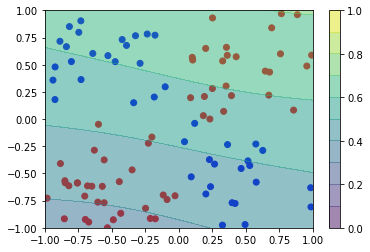

In [42]:
import matplotlib.pyplot as plt

def create_toy_dataset():
  x = np.random.uniform(-1., 1., size=(100,2) ) #(100,2)
  labels = (np.prod(x, axis=1) > 0).astype(np.float)
  return x, labels.reshape(-1,1)

x, labels = create_toy_dataset()
colors = ["blue", "red"]
plt.scatter(x[:, 0], x[:, 1], c=[colors[int(label)] for label in labels])

layers = [TanhLayer(2, 4), LinearLayer(4, 1)]
cost_function = SigmoidCrossEntropy()
nn = NeuralNetwork(layers, cost_function)
#nn._gradient_check()
for i in range(100000):
    if i % 10000 == 0:
        print("step %6d, cost %f" % (i, nn.cost(x, labels)))
        nn.fit(x, labels, learning_rate=0.001)

X_test, Y_test = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x_test = np.array([X_test, Y_test]).transpose(1, 2, 0).reshape(-1, 2)
probs = nn(x_test)
Probs = probs.reshape(100, 100)
levels = np.linspace(0, 1, 11)
plt.contourf(X_test, Y_test, Probs, levels, alpha=0.5)
plt.colorbar()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [43]:
import numpy as np
from scipy.stats import truncnorm


class Layer(object):

    def __init__(self, dim_input, dim_output, std=1., bias=0.):
        self.w = truncnorm(a=-2 * std, b=2 * std, scale=std).rvs((dim_input, dim_output))
        self.b = np.ones(dim_output) * bias

    def __call__(self, X):
        self.input = X
        return self.forward_propagation(X)

    def back_propagation(self, delta, learning_rate):
        # derivative with respect to activation
        delta = delta * self.activation_derivative()

        w = np.copy(self.w)
        self.w -= learning_rate * self.input.T.dot(delta)
        self.b -= learning_rate * np.sum(delta, axis=0)

        # derivative with respect to input
        return delta.dot(w.T)


class LinearLayer(Layer):

    def forward_propagation(self, X):
        return X.dot(self.w) + self.b

    def activation_derivative(self):
        return 1


class SigmoidLayer(Layer):

    def forward_propagation(self, X):
        activation = X.dot(self.w) + self.b
        self.output = 1 / (1 + np.exp(-activation))
        return self.output

    def activation_derivative(self):
        return self.output * (1 - self.output)


class TanhLayer(Layer):

    def forward_propagation(self, X):
        activation = X.dot(self.w) + self.b
        self.output = np.tanh(activation)
        return self.output

    def activation_derivative(self):
        return 1 - self.output ** 2


class ReLULayer(Layer):

    def forward_propagation(self, X):
        activation = X.dot(self.w) + self.b
        self.output = activation.clip(min=0)
        return self.output

    def activation_derivative(self):
        return (self.output > 0).astype(np.float)


class SigmoidCrossEntropy(object):

    def activate(self, logits):
        return 1 / (1 + np.exp(-logits))

    def __call__(self, logits, targets):
        probs = self.activate(logits)
        p = np.clip(probs, 1e-10, 1 - 1e-10)
        return np.sum(-targets * np.log(p) - (1 - targets) * np.log(1 - p))

    def delta(self, logits, targets):
        probs = self.activate(logits)
        return probs - targets


class SoftmaxCrossEntropy(object):

    def activate(self, logits):
        a = np.exp(logits - np.max(logits, 1, keepdims=True))
        a /= np.sum(a, 1, keepdims=True)
        return a

    def __call__(self, logits, targets):
        probs = self.activate(logits)
        p = probs.clip(min=1e-10)
        return - np.sum(targets * np.log(p))

    def delta(self, logits, targets):
        probs = self.activate(logits)
        return probs - targets


class SumSquaresError(object):

    def activate(self, X):
        return X

    def __call__(self, X, targets):
        return 0.5 * np.sum((X - targets) ** 2)

    def delta(self, X, targets):
        return X - targets

class NeuralNetwork(object):

    def __init__(self, layers, cost_function):
        self.layers = layers
        self.cost_function = cost_function

    def __call__(self, X):
        for layer in self.layers:
            X = layer(X)
        return self.cost_function.activate(X)

    def fit(self, X, t, learning_rate):
        for layer in self.layers:
            X = layer(X)

        delta = self.cost_function.delta(X, t)
        for layer in reversed(self.layers):
            delta = layer.back_propagation(delta, learning_rate)

    def cost(self, X, t):
        for layer in self.layers:
            X = layer(X)
        return self.cost_function(X, t)

import matplotlib.pyplot as plt
import numpy as np

def create_toy_dataset():
    x = np.random.uniform(-1., 1., size=(1000, 2))
    labels = (np.prod(x, axis=1) > 0).astype(np.float)
    return x, labels.reshape(-1, 1)


step      0, cost 981.763365
step  10000, cost 35.463606
step  20000, cost 34.521172
step  30000, cost 34.448497
step  40000, cost 34.625357
step  50000, cost 34.875827
step  60000, cost 28.307439
step  70000, cost 43.770516
step  80000, cost 58.842770
step  90000, cost 22.383695


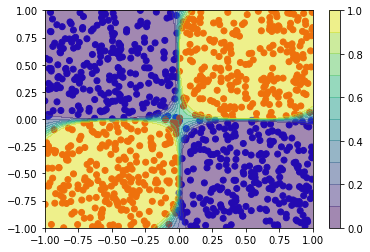

In [45]:
    x, labels = create_toy_dataset()
    colors = ["blue", "red"]
    plt.scatter(x[:, 0], x[:, 1], c=[colors[int(label)] for label in labels])

    layers = [TanhLayer(2, 4), LinearLayer(4, 1)]
    cost_function = SigmoidCrossEntropy()
    nn = NeuralNetwork(layers, cost_function)
    #nn._gradient_check()
    for i in range(100000):
        if i % 10000 == 0:
            print("step %6d, cost %f" % (i, nn.cost(x, labels)))
        nn.fit(x, labels, learning_rate=0.001)

    X_test, Y_test = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    x_test = np.array([X_test, Y_test]).transpose(1, 2, 0).reshape(-1, 2)
    probs = nn(x_test)
    Probs = probs.reshape(100, 100)
    levels = np.linspace(0, 1, 11)
    plt.contourf(X_test, Y_test, Probs, levels, alpha=0.5)
    plt.colorbar()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()